In [1]:
from math import sqrt

import numpy as np
import seaborn as sns

sns.set_palette('muted')
sns.set_style('whitegrid')

In [2]:
def generate_rnorms(N, Ws, params_list):
    rnorms = [np.random.normal(params[0], params[1], round(N*w)) for params, w in zip(params_list, Ws)]
    mix = np.concatenate(rnorms)
    mix_strs = [f'{w}×N({params[0]}, {params[1]})' for params, w in zip(params_list, Ws)]
    print (' + '.join(mix_strs))
    print(f'Population mean: {np.mean(mix)}')
    print(f'Population variance: {np.var(mix)}')
    _ = sns.kdeplot(mix, bw=0.5)
    return rnorms

In [3]:
def print_modelling_and_estimation_results(choice, iters, n, rnorms, Ws, params_list):
    print(f'Choice: {choice}')
    if choice.startswith('stratify'):
        strat_sample_sizes = get_strat_sample_sizes(n, Ws, params_list, strategy=choice.rsplit('_', 1)[1])
        n = strat_sample_sizes
        print(f'Strat samples sizes: {n}')
    
    print('Modelling results')
    modelling_stats = model_point_estimates(choice, iters, n, rnorms)
    print_stats(modelling_stats)
    
    if choice.startswith('stratify'):
        print('Estimation results')
        estimation_stats = estimate_point_estimates(rnorms, strat_sample_sizes, Ws)
        print_stats(estimation_stats)

def print_stats(stats):
    print(f'\tMean mean: {stats[0]}')
    print(f'\tMean variance: {stats[1]}')
    print(f'\tVariance mean: {stats[2]}')
    print(f'\tVariance variance: {stats[3]}')

In [4]:
def get_strat_sample_sizes(n, Ws, params_list, strategy):
    if strategy == 'prop':
        nks = [int(n * w) for w in Ws]
    elif strategy == 'optimal':
        np_Ws = np.array(Ws)
        np_sigmas = np.array([sqrt(sigma_square) for _, sigma_square in params_list])
        props = np.divide(np.multiply(np_Ws, np_sigmas), np.dot(np_Ws, np_sigmas))
        nks = [int(round(n * prop)) for prop in props]
    return nks

In [5]:
def model_point_estimates(choice, iters, n, rnorms):
    """Models point estimates by repeated sampling.
    
    If `choice` is stratification based `n` is expected to be list of strat sample sizes. 
    """
    means = []
    variances = []
    for i in range(iters):    
        if choice == 'simple':
            mix = np.concatenate(rnorms)
            sample = np.random.choice(mix, n)
            means.append(np.mean(sample))
            variances.append(np.var(sample))
        elif choice.startswith('stratify'):
            strat_samples = [np.random.choice(rnorm, nk) for rnorm, nk in zip(rnorms, n)]
            strat_mix = np.concatenate(strat_samples)
            means.append(np.mean(strat_mix))
            variances.append(np.var(strat_mix))
    return np.mean(means), np.var(means), np.mean(variances), np.var(variances)

In [6]:
def estimate_point_estimates(rnorms, strat_sample_sizes, Ws):
    strat_samples = [np.random.choice(rnorm, nk) for rnorm, nk in zip(rnorms, strat_sample_sizes)]
    strat_means = np.array([np.mean(sample) for sample in strat_samples])
    strat_vars = np.array([np.var(sample) for sample in strat_samples])
    w = np.array(Ws)
    strats_number = len(strat_sample_sizes)
    
    mean_mean = np.dot(w, strat_means)
    mean_var = np.dot(np.square(w), strat_vars)
    w_dot_mean_minus_mean = np.subtract(np.dot(w, strat_means), strat_means)
    var_mean = np.add(np.dot(w, strat_vars), np.dot(w, np.square(w_dot_mean_minus_mean)))
    var_var = np.add(np.dot(w, strat_vars), np.var(np.dot(w, np.square(w_dot_mean_minus_mean))))
    
    return mean_mean, mean_var, var_mean, var_var

In [7]:
_iters = 1000
_N = 500
_n = 100
_Ws = [0.3, 0.5, 0.2]

### Same means and vars

0.3×N(3, 1) + 0.5×N(3, 1) + 0.2×N(3, 1)
Population mean: 2.9868559167465545
Population variance: 0.8917224641450676


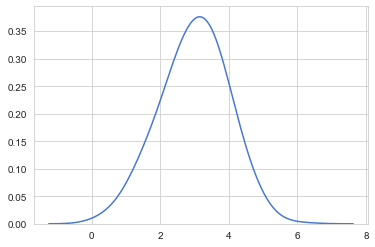

In [8]:
_params_list = [(3, 1), (3, 1), (3, 1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [9]:
print_modelling_and_estimation_results('simple', _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 2.9820760558237605
	Mean variance: 0.008947994735423187
	Variance mean: 0.8879288881525723
	Variance variance: 0.015792697525378537


##### Stratified proportionally

In [10]:
print_modelling_and_estimation_results('stratify_prop', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_prop
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 2.9862463482641166
	Mean variance: 0.009016385361579934
	Variance mean: 0.8810376599408267
	Variance variance: 0.01740100107052865
Estimation results
	Mean mean: 3.0858773634373384
	Mean variance: 0.2924177053059192
	Variance mean: 0.8397332174484887
	Variance variance: 0.8157396352807635


##### Stratified optimally

In [11]:
print_modelling_and_estimation_results('stratify_optimal', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_optimal
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 2.986845684837375
	Mean variance: 0.009153017295977723
	Variance mean: 0.8884764828291479
	Variance variance: 0.015191804111417639
Estimation results
	Mean mean: 3.0317805059743197
	Mean variance: 0.37133825083421934
	Variance mean: 0.9699415298533218
	Variance variance: 0.966289866981949


### Different means same vars

0.3×N(0, 1) + 0.5×N(10, 1) + 0.2×N(3, 1)
Population mean: 5.58125870724071
Population variance: 21.957665153793837


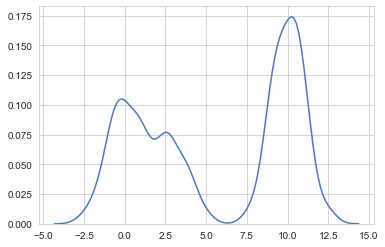

In [12]:
_params_list = [(0, 1), (10, 1), (3, 1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [13]:
print_modelling_and_estimation_results('simple', _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 5.550779650816825
	Mean variance: 0.21896821906199967
	Variance mean: 21.77723111499683
	Variance variance: 1.681975261074307


##### Stratified proportionally

In [14]:
print_modelling_and_estimation_results('stratify_prop', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_prop
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 5.581473326261635
	Mean variance: 0.01026468567145191
	Variance mean: 21.915981869006714
	Variance variance: 0.8969505223616745
Estimation results
	Mean mean: 5.5915718866700805
	Mean variance: 0.3992487535415992
	Variance mean: 21.136287679406944
	Variance variance: 1.0974326719810996


##### Stratified optimally

In [15]:
print_modelling_and_estimation_results('stratify_optimal', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_optimal
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 5.584114405970566
	Mean variance: 0.009905903765232217
	Variance mean: 21.86602259184226
	Variance variance: 0.8530893815875622
Estimation results
	Mean mean: 5.525446626462577
	Mean variance: 0.46313442663280163
	Variance mean: 22.393481223784008
	Variance variance: 1.2713517157587073


### Different means and vars

0.3×N(0, 0.5) + 0.5×N(10, 1) + 0.2×N(3, 0.1)
Population mean: 5.598416780447328
Population variance: 21.230518262078206


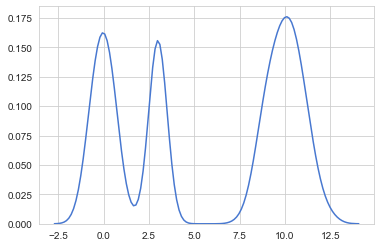

In [16]:
_params_list = [(0, .5), (10, 1), (3, .1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [17]:
print_modelling_and_estimation_results('simple', _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 5.596311939747964
	Mean variance: 0.208119315887363
	Variance mean: 21.021720443408622
	Variance variance: 1.2889975930887618


##### Stratified proportionally

In [18]:
print_modelling_and_estimation_results('stratify_prop', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_prop
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 5.598857374728994
	Mean variance: 0.005118619329204162
	Variance mean: 21.196525912208237
	Variance variance: 0.4584516263407971
Estimation results
	Mean mean: 5.670820434493667
	Mean variance: 0.20471958106946292
	Variance mean: 21.668619916956644
	Variance variance: 0.4369808283845216


##### Stratified optimally

In [19]:
print_modelling_and_estimation_results('stratify_optimal', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_optimal
Strat samples sizes: [27, 64, 8]
Modelling results
	Mean mean: 6.712537514817631
	Mean variance: 0.005888343260379491
	Variance mean: 21.297279625714534
	Variance variance: 0.38418679039687265
Estimation results
	Mean mean: 5.662976334328892
	Mean variance: 0.2599781684109496
	Variance mean: 21.563795089626527
	Variance variance: 0.5673076777284787
